In [1]:
from binary_trie import Trie, bytes_to_bit_string, int_to_bit_string

In [2]:
t = Trie()

In [58]:
import multihash as mh
import hashlib as hl  

def multihash_to_kad_id(peer_id: str) -> bytes:  
    multi_hash = mh.from_b58_string(peer_id)
    return hl.sha256(multi_hash).digest()

# this should be a clean way (even if it could be done in less lines it is more readable)
def xor_distance(bytes0: bytes, bytes1: bytes):
    xor=bytearray()
    maxlen=max(len(bytes0), len(bytes1))

    for i in range(maxlen):
        byte0 = bytes0[i if len(bytes0)>len(bytes1) else i-len(bytes1)+len(bytes0)] if i >= maxlen-len(bytes0) else 0
        byte1 = bytes1[i if len(bytes1)>len(bytes0) else i-len(bytes0)+len(bytes1)] if i >= maxlen-len(bytes1) else 0
        xor.append(byte0 ^ byte1)

    return bytes(xor)

def bit_string_to_bytes(s):
    v = int(s, 2)
    b = bytearray()
    while v:
        b.append(v & 0xff)
        v >>= 8
    return bytes(b[::-1])

# get the corresponding k-bucket for the given XOR distance in bytes
def bucket_number_for_distance(d: bytes) -> int:
    count=0
    # iterate on the bytes from left to right
    for b in d:
        # while the byte==0, add 8 (bits) to the counter
        count+=8
        if b!=0:
            # at the first non null byte, shift right until this byte==0
            while b!=0:
                b>>=1
                # for each right shift, remove 1 to counter
                count-=1
            break
    # return the length of the byte string minus the number of leading 0 bits
    return 256-(8*len(d)-count)


In [46]:
import csv

filename = "nebula-peers.csv"
with open(filename, 'r') as file:
    nebula_peers = [line for line in csv.reader(file)]

In [137]:
class NebulaPeer:
    def __init__(self, nebula_id, peer_id, neighbors_ids):
        self.nebula_id = nebula_id
        self.peer_id = peer_id
        self.neighbors_ids = neighbors_ids
        
        self.key = multihash_to_kad_id(peer_id)
        
        self.alive = len(neighbors_ids)>0
        
        self.buckets = [[] for _ in range(257)]
        self.neighbors = []
        
    def distance(self, p):
        return xor_distance(self.key, p.key)
        
    def addNeighbor(self, peer):
        self.neighbors.append(peer)
        self.buckets[bucket_number_for_distance(self.distance(peer))].append(peer)
        
    def __str__(self):
        return "nebula_id: "+str(self.nebula_id)+", peer_id: "+str(self.peer_id)+", neighbors: "+str(self.neighbors_ids)

In [138]:
peers = {line[0]: NebulaPeer(line[0], line[1], line[2:]) for line in nebula_peers}

In [139]:
peers_binary = {peers[p].key: peers[p] for p in peers}

In [140]:
for p in peers:
    for n in peers[p].neighbors_ids:
        peers[p].addNeighbor(peers[n])

In [141]:
t = Trie()
for p in peers:
    t.add(bytes_to_bit_string(peers[p].key))

In [142]:
neighborCount=2000

In [143]:
count=0

buckets=[0 for _ in range(257)]

for p in peers:
    if not peers[p].alive:
        continue
    # get 200 closest neighbors from the trie
    closest200=t.nClosest(bytes_to_bit_string(peers[p].key),neighborCount)
    
    cc=0
    # skip self
    for c in closest200[1:]:
        # for each of the 200 closest neighbors
        b=bit_string_to_bytes(c)
        # get its byte key
        # if the peers is dead, skip it
        if b in peers_binary and not peers_binary[b].alive:
            continue
            
        # compute in which bucket it belongs
        d=xor_distance(peers[p].key,b)
        bucket=bucket_number_for_distance(d)
        
        # if bucket is full we are done with this peer and its neighbors
        if len(peers[p].buckets[bucket])+cc>=20:
            break
            # we are done, only full buckets from here on
        
        # we want to find c in the appropriate bucket
        found=False
        for peer in peers[p].buckets[bucket]:
            if peer.key==b:
                found=True
                break
        if not found:
            buckets[bucket]+=1
            cc+=1
        
    count+=1
        
print(count)

15570


In [144]:
ratio_bucket = [n/count for n in buckets]

In [145]:
print(ratio_bucket[230:])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


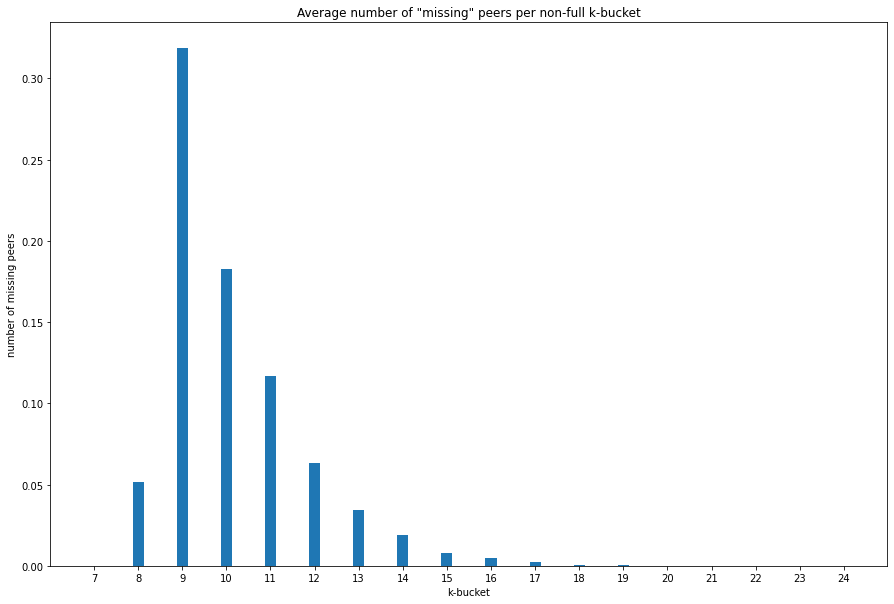

In [157]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,10))
plt.xticks(np.arange(7, 25, 1))

plt.bar(range(7,25), ratio_bucket[7:25], width=0.25)
#plt.bar([x+232 for x in range(len(ratio_bucket[232:]))], ratio_bucket[232:], width=0.25)

plt.title('Average number of "missing" peers per non-full k-bucket')
plt.xlabel("k-bucket")
plt.ylabel("number of missing peers")

plt.show()

In [59]:
closest_peers = [[] for _ in range(20)]

for p in peers:
    if not peers[p].alive:
        continue
    # get 20 closest neighbors from the trie
    closest20 = t.nClosest(bytes_to_bit_string(peers[p].key), 21)[1:]
    
    for i in range(len(closest20)):
        b=bit_string_to_bytes(closest20[i])
        d=xor_distance(peers[p].key,b)
        bucket=bucket_number_for_distance(d)

        closest_peers[i].append(bucket)
        
print(closest_peers)

[[17, 14, 14, 15, 13, 14, 14, 16, 18, 14, 15, 20, 12, 13, 13, 14, 15, 17, 12, 15, 13, 14, 18, 13, 13, 15, 17, 16, 16, 15, 13, 15, 14, 17, 18, 14, 14, 13, 13, 14, 15, 16, 17, 15, 16, 14, 14, 14, 15, 18, 14, 15, 12, 16, 16, 15, 16, 15, 14, 16, 13, 13, 15, 14, 16, 14, 15, 15, 13, 13, 15, 16, 13, 20, 16, 14, 18, 13, 13, 15, 15, 14, 16, 14, 15, 15, 14, 15, 16, 15, 18, 19, 15, 15, 15, 15, 15, 13, 14, 16, 15, 13, 13, 15, 15, 16, 17, 16, 13, 16, 15, 17, 15, 14, 16, 15, 16, 13, 14, 15, 14, 14, 18, 18, 14, 14, 14, 13, 14, 15, 12, 16, 16, 15, 14, 22, 15, 16, 16, 14, 14, 14, 18, 14, 15, 14, 14, 17, 14, 15, 14, 15, 17, 13, 13, 16, 14, 14, 14, 18, 13, 15, 14, 15, 15, 13, 13, 13, 17, 17, 15, 14, 16, 15, 13, 14, 16, 14, 16, 19, 12, 13, 17, 13, 17, 17, 13, 15, 13, 14, 13, 20, 14, 13, 17, 13, 12, 16, 14, 14, 14, 14, 12, 13, 16, 14, 13, 16, 15, 16, 16, 16, 16, 15, 13, 17, 13, 13, 20, 14, 14, 14, 19, 15, 16, 14, 16, 13, 15, 17, 15, 15, 15, 17, 13, 13, 16, 14, 15, 17, 17, 16, 13, 14, 18, 16, 16, 15, 19, 21

[[], [], [], [], [], [], [], [], [], [14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18

In [73]:
data = []
for line in closest_peers:
    data.append(sum(line)/len(line))
print(data)

[15.217148362235067, 13.764739884393064, 13.05504174694926, 12.567758509955041, 12.207450224791264, 11.921708413615928, 11.675337186897881, 11.472832369942196, 11.298330122029544, 11.145600513808606, 10.993962748876044, 10.870199100834938, 10.738921001926782, 10.633654463712267, 10.521901091843288, 10.412395632626847, 10.316955684007707, 10.225112395632626, 10.157546563904946, 10.102312138728324]


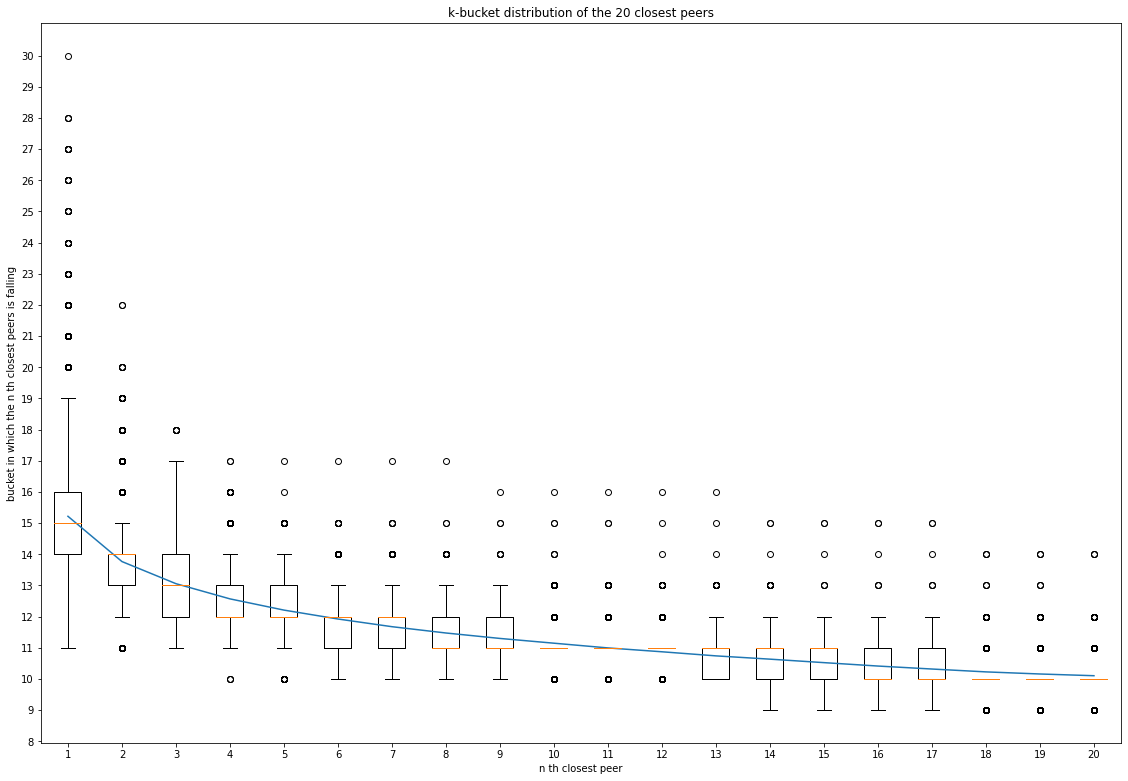

In [158]:
import numpy as np

fig = plt.figure(figsize=(15,10))
ax = fig.add_axes([0, 0, 1, 1])

plt.yticks(np.arange(5, 31, 1))

plt.xlabel("n th closest peer")
plt.ylabel("bucket in which the n th closest peers is falling")

#plt.title("IPFS network: Kademlia k-bucket filling")

bp = ax.boxplot(closest_peers)
ax.plot(range(1,21),data)

plt.title("k-bucket distribution of the 20 closest peers")
 
# show plot
plt.show()

In [84]:
bucket_distrib = [[] for _ in range(31)]
for i in range(len(closest_peers)):
    for v in closest_peers[i]:
        bucket_distrib[v].append(i+1)
print(bucket_distrib)

[[], [], [], [], [], [], [], [], [], [14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18

In [127]:
xClosest = []
for i in range(len(closest_peers)):
    total=sum([closest_peers[i].count(b) for b in range(9,26)])
    xClosest.append([closest_peers[i].count(b)/total for b in range(9,26)])


In [128]:
xClosest[0]

[0.0,
 0.0,
 0.00045004500450045,
 0.02616690240452617,
 0.1321846470361322,
 0.23627362736273627,
 0.23434486305773433,
 0.1694097981226694,
 0.09483091166259483,
 0.05066220907805066,
 0.02725986884402726,
 0.014272855857014273,
 0.008357978655008359,
 0.0032146071750032146,
 0.0016715957310016716,
 0.0005143371480005143,
 0.00038575286100038574]

In [129]:
xClosest[4][11]

0.0

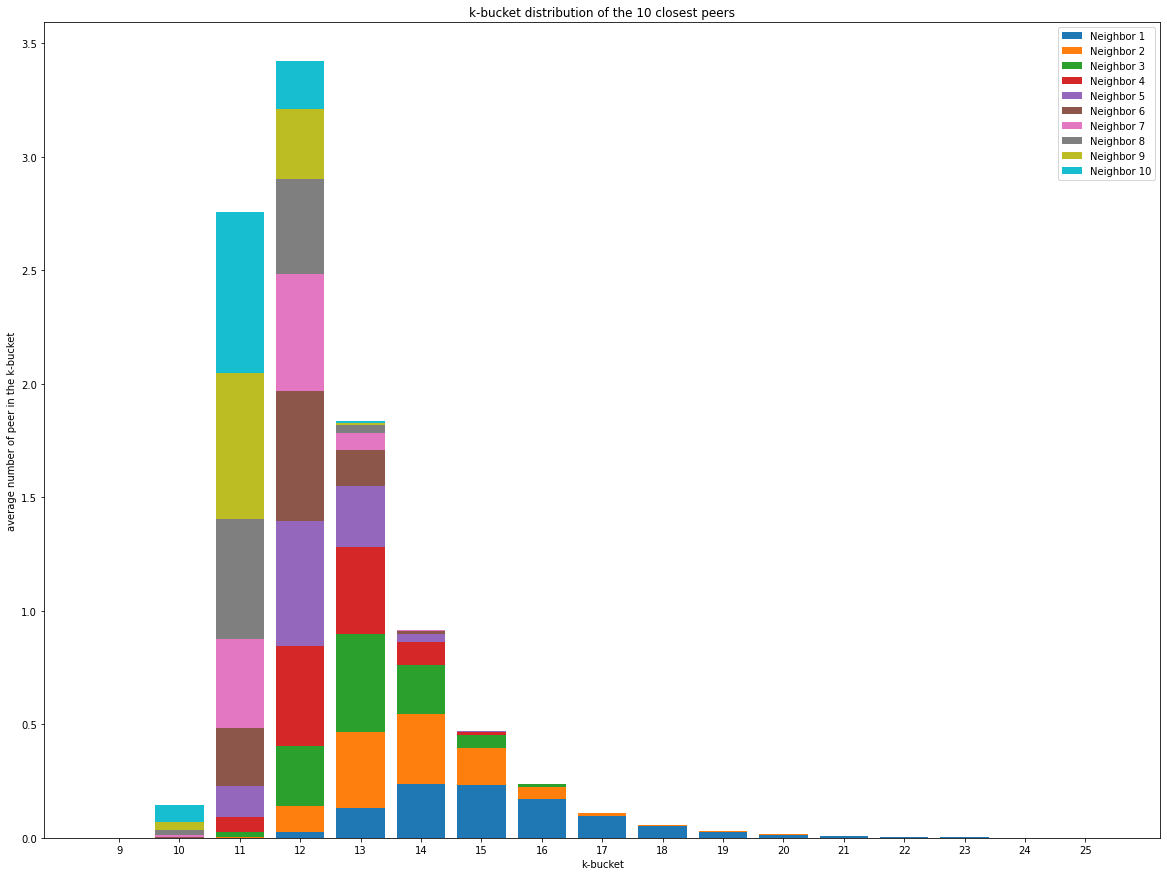

In [133]:
fig, ax = plt.subplots(figsize=(20,15))
plt.xticks(np.arange(9, 26, 1))

cumsum=[0 for _ in range(9,26)]

for i in range(10):
    label="Neighbor "+str(i+1)
    ax.bar(range(9,26), xClosest[i], bottom=cumsum, label=label)        
    cumsum = [cumsum[j]+xClosest[i][j] for j in range(len(cumsum))]
_=ax.legend()
_=plt.title("k-bucket distribution of the 10 closest peers")
_=plt.xlabel("k-bucket")
_=plt.ylabel("average number of peer in the k-bucket")

In [ ]:
alive_peers = {line[0]: NebulaPeer(line[0], line[1], line[2:]) for line in nebula_peers if len(line)>2}

In [ ]:
print(len(alive_peers))